In [1]:
import torch
from torch import nn

import math
import matplotlib.pyplot as plt

import torchvision
import torchvision.transforms as transforms

import numpy


In [2]:
torch.manual_seed(111)

In [3]:
device = ""
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)

In [6]:
train_set = torchvision.datasets.FashionMNIST(
    root=".", train=True, download=True, transform=transform
)

100.0%

Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw


111.0%

Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw


100.0%

Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw


159.1%

Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw
Processing...
Done!


In [7]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True
)

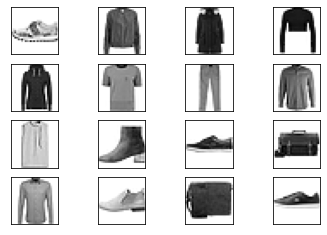

In [8]:
real_samples, mnist_labels = next(iter(train_loader))
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(real_samples[i].reshape(28, 28), cmap="gray_r")
    plt.xticks([])
    plt.yticks([])

In [9]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = x.view(x.size(0), 784)
        output = self.model(x)
        return output

In [10]:
discriminator = Discriminator().to(device=device)

In [11]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 784),
            nn.Tanh(),
        )

    def forward(self, x):
        output = self.model(x)
        output = output.view(x.size(0), 1, 28, 28)
        return output

generator = Generator().to(device=device)

In [12]:
lr = 0.0001
num_epochs = 50
loss_function = nn.BCELoss()

optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

In [13]:
for epoch in range(num_epochs):
    for n, (real_samples, mnist_labels) in enumerate(train_loader):
        # Data for training the discriminator
        real_samples = real_samples.to(device=device)
        real_samples_labels = torch.ones((batch_size, 1)).to(
            device=device
        )
        latent_space_samples = torch.randn((batch_size, 100)).to(
            device=device
        )
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1)).to(
            device=device
        )
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat(
            (real_samples_labels, generated_samples_labels)
        )

        # Training the discriminator
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(
            output_discriminator, all_samples_labels
        )
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # Data for training the generator
        latent_space_samples = torch.randn((batch_size, 100)).to(
            device=device
        )

        # Training the generator
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(
            output_discriminator_generated, real_samples_labels
        )
        loss_generator.backward()
        optimizer_generator.step()

        # Show loss
        if n == batch_size - 1:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
            print(f"Epoch: {epoch} Loss G.: {loss_generator}")

Epoch: 0 Loss D.: 0.5313327312469482
Epoch: 0 Loss G.: 0.5252000093460083
Epoch: 1 Loss D.: 0.13883674144744873
Epoch: 1 Loss G.: 5.462947845458984
Epoch: 2 Loss D.: 0.13050736486911774
Epoch: 2 Loss G.: 4.72999382019043
Epoch: 3 Loss D.: 0.028970301151275635
Epoch: 3 Loss G.: 4.214488983154297
Epoch: 4 Loss D.: 0.21257640421390533
Epoch: 4 Loss G.: 3.388322591781616
Epoch: 5 Loss D.: 0.09741932153701782
Epoch: 5 Loss G.: 3.1514008045196533
Epoch: 6 Loss D.: 0.35695400834083557
Epoch: 6 Loss G.: 1.9509539604187012
Epoch: 7 Loss D.: 0.3262321949005127
Epoch: 7 Loss G.: 1.8007179498672485
Epoch: 8 Loss D.: 0.35581934452056885
Epoch: 8 Loss G.: 1.4853938817977905
Epoch: 9 Loss D.: 0.5373007655143738
Epoch: 9 Loss G.: 1.5013861656188965
Epoch: 10 Loss D.: 0.5787784457206726
Epoch: 10 Loss G.: 1.3910273313522339
Epoch: 11 Loss D.: 0.5262178182601929
Epoch: 11 Loss G.: 1.4461655616760254
Epoch: 12 Loss D.: 0.4729090631008148
Epoch: 12 Loss G.: 1.3660573959350586
Epoch: 13 Loss D.: 0.55271464

In [14]:
latent_space_samples = torch.randn(batch_size, 100).to(device=device)
generated_samples = generator(latent_space_samples)

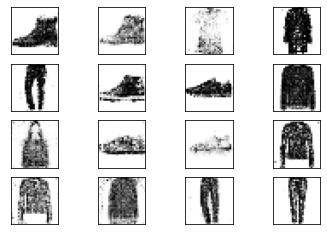

In [15]:
generated_samples = generated_samples.cpu().detach()
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(generated_samples[i].reshape(28, 28), cmap="gray_r")
    plt.xticks([])
    plt.yticks([])